In [152]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Probit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve
from scipy.stats import chi2_contingency, f_oneway

## Merging the overall dataset

In [115]:
application_data = pd.read_csv('application_record.csv')
credit_data = pd.read_csv('credit_record.csv')
merged_data = pd.merge(application_data, credit_data, on='ID', how='inner')

## Preprocessing categorical columns to fit into the models

In [116]:
merged_data['CODE_GENDER'] = merged_data['CODE_GENDER'].replace({'M': 0, 'F': 1})
merged_data['FLAG_OWN_CAR'] = merged_data['FLAG_OWN_CAR'].replace({'N': 0, 'Y': 1})
merged_data['FLAG_OWN_REALTY'] = merged_data['FLAG_OWN_REALTY'].replace({'N': 0, 'Y': 1})
merged_data['STATUS'] = merged_data['STATUS'].replace({
    'C': 0, 'X': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 5
})


# merged_data['NAME_FAMILY_STATUS'] = merged_data['NAME_FAMILY_STATUS'].replace({
#     'Married': 1,
#     'Civil marriage': 2,
#     'Separated': 3,
#     'Single / not married': 4,
#     'Widow': 5
# })
#
merged_data['NAME_EDUCATION_TYPE'] = merged_data['NAME_EDUCATION_TYPE'].replace({
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
})



print(merged_data.head())

        ID  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN   
0  5008804            0             1                1             0  \
1  5008804            0             1                1             0   
2  5008804            0             1                1             0   
3  5008804            0             1                1             0   
4  5008804            0             1                1             0   

   AMT_INCOME_TOTAL NAME_INCOME_TYPE  NAME_EDUCATION_TYPE NAME_FAMILY_STATUS   
0          427500.0          Working                    4     Civil marriage  \
1          427500.0          Working                    4     Civil marriage   
2          427500.0          Working                    4     Civil marriage   
3          427500.0          Working                    4     Civil marriage   
4          427500.0          Working                    4     Civil marriage   

  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE   
0  Rent

## Filter the columns that definitely don`t care information

In [117]:
selected_columns = ['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
                    'AMT_INCOME_TOTAL', 'NAME_EDUCATION_TYPE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'STATUS']
filtered_data = merged_data[selected_columns]

## Look at the Corelation matrix

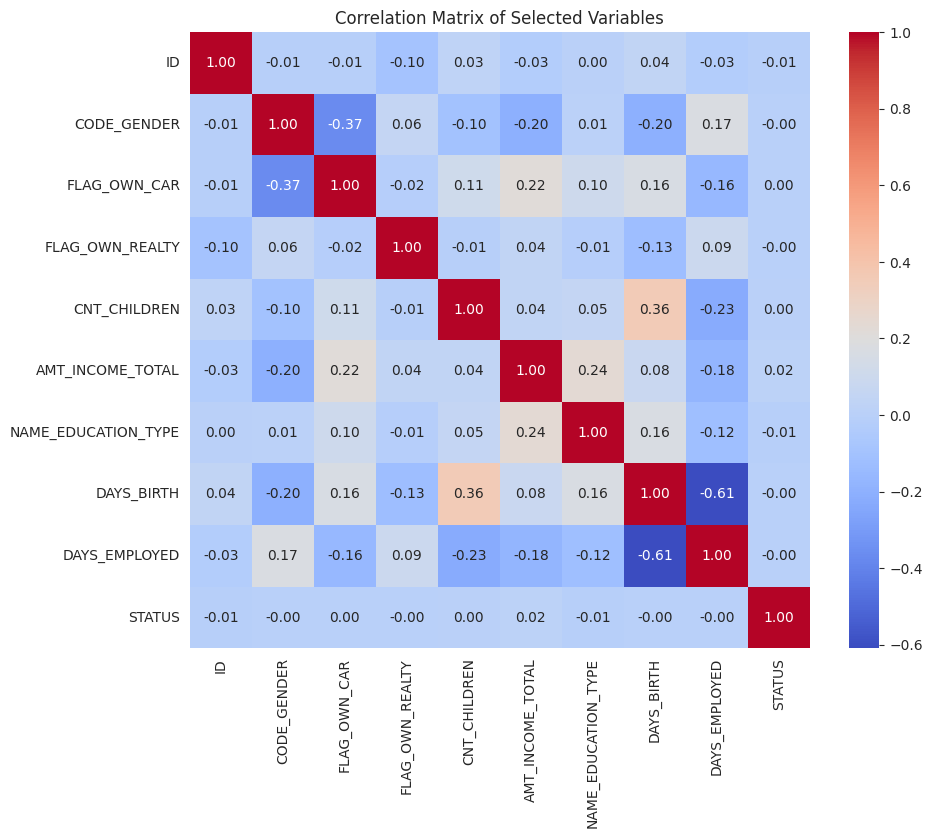

In [118]:
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Selected Variables')
plt.show()

## Check for missing values

In [119]:
missing_values = filtered_data.isnull().sum()
print(missing_values)

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_EDUCATION_TYPE    0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
STATUS                 0
dtype: int64


## Check for outliers

In [120]:
num_cols = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED']

In [121]:
outliers_info = {}
for col in num_cols:
    Q1 = filtered_data[col].quantile(0.25)
    Q3 = filtered_data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = filtered_data[(filtered_data[col] < lower_bound) | (filtered_data[col] > upper_bound)]
    outliers_info[col] = [outliers.shape[0], round((outliers.shape[0] / filtered_data.shape[0]) * 100, 2)]

outliers_info_df = pd.DataFrame.from_dict(outliers_info, orient='index', columns=['Number of Outliers', 'Percentage (%)'])

print(outliers_info_df)

                  Number of Outliers  Percentage (%)
CNT_CHILDREN                   11039            1.42
AMT_INCOME_TOTAL               33987            4.37
DAYS_BIRTH                         0            0.00
DAYS_EMPLOYED                 163348           21.00


In [122]:
# filtered_data = filtered_data.drop(['DAYS_EMPLOYED'], axis=1)

In [123]:
filtered_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,STATUS
0,5008804,0,1,1,0,427500.0,4,-12005,-4542,0
1,5008804,0,1,1,0,427500.0,4,-12005,-4542,0
2,5008804,0,1,1,0,427500.0,4,-12005,-4542,0
3,5008804,0,1,1,0,427500.0,4,-12005,-4542,0
4,5008804,0,1,1,0,427500.0,4,-12005,-4542,0


## Small fix of negative values

In [124]:
filtered_data['DAYS_BIRTH'] = abs(filtered_data['DAYS_BIRTH'])
filtered_data['DAYS_EMPLOYED'] = abs(filtered_data['DAYS_EMPLOYED'])

/tmp/ipykernel_23666/634289122.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DAYS_BIRTH'] = abs(filtered_data['DAYS_BIRTH'])
/tmp/ipykernel_23666/634289122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DAYS_EMPLOYED'] = abs(filtered_data['DAYS_EMPLOYED'])


## Aggregating the final dataset with one binary value default per card

In [125]:
aggregated_data = filtered_data.groupby('ID').agg({
    'CODE_GENDER': 'max',
    'FLAG_OWN_CAR': 'max',
    'FLAG_OWN_REALTY': 'max',
    'CNT_CHILDREN': 'max',
    'AMT_INCOME_TOTAL': 'mean',
    'NAME_EDUCATION_TYPE': 'max',
    'DAYS_BIRTH': 'mean',
    'DAYS_EMPLOYED': 'mean',
    'STATUS': 'max'
}).reset_index()
aggregated_data['DEFAULT'] = np.where(aggregated_data['STATUS'] > 0, 1, 0)
final_data = aggregated_data.drop(['ID', 'STATUS'], axis=1)


In [126]:
final_data.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,DEFAULT
0,0,1,1,0,427500.0,4,12005.0,4542.0,1
1,0,1,1,0,427500.0,4,12005.0,4542.0,1
2,0,1,1,0,112500.0,2,21474.0,1134.0,1
3,1,0,1,0,270000.0,2,19110.0,3051.0,1
4,1,0,1,0,270000.0,2,19110.0,3051.0,0


## Defining an dependent variable

In [144]:
X = final_data.drop('DEFAULT', axis=1)
y = final_data['DEFAULT']



## Selecting a features (it was useless)

In [145]:
selected_features = []
p_values = []

for col in X.columns:
    if X[col].dtype == 'object':
        contingency_table = pd.crosstab(X[col], y)
        _, p, _, _ = chi2_contingency(contingency_table)
    else:
        groups = [X[y == 0][col].values, X[y == 1][col].values]
        _, p = f_oneway(*groups)

    if p < 0.05:  # Set a significance level (e.g., 0.05)
        selected_features.append(col)
        p_values.append(p)

# Select features based on p-values
X_selected = X[selected_features]

In [146]:
print(selected_features)

['AMT_INCOME_TOTAL']


## Spliting the dataset into training and testing

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logit modeling and evaluation

In [148]:
logit_model = sm.Logit(y_train, sm.add_constant(X_train))
logit_result = logit_model.fit()
logit_predictions = logit_result.predict(sm.add_constant(X_test))
logit_auc = roc_auc_score(y_test, logit_predictions)
logit_accuracy = accuracy_score(y_test, logit_predictions.round())
logit_precision = precision_score(y_test, logit_predictions.round())
logit_recall = recall_score(y_test, logit_predictions.round())
logit_f1 = f1_score(y_test, logit_predictions.round())

Optimization terminated successfully.
         Current function value: 0.372750
         Iterations 6


## Random Forest modeling and evaluation

In [149]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, rf_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions.round())
rf_precision = precision_score(y_test, rf_predictions.round())
rf_recall = recall_score(y_test, rf_predictions.round())
rf_f1 = f1_score(y_test, rf_predictions.round())


In [150]:
# Compare Model Performances
print("Logistic Regression:")
print("AUC:", logit_auc)
print("Accuracy:", logit_accuracy)
print("Precision:", logit_precision)
print("Recall:", logit_recall)
print("F1-score:", logit_f1)


print("\nRandom Forest:")
print("AUC:", rf_auc)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)

Logistic Regression:
AUC: 0.5015890626201724
Accuracy: 0.8812397147558969
Precision: 0.8812397147558969
Recall: 1.0
F1-score: 0.9368712640326577

Random Forest:
AUC: 0.7651625828673785
Accuracy: 0.8815139879319802
Precision: 0.9106615475487301
Recall: 0.9596949891067538
F1-score: 0.9345355356872254


## Roc curve for random forest

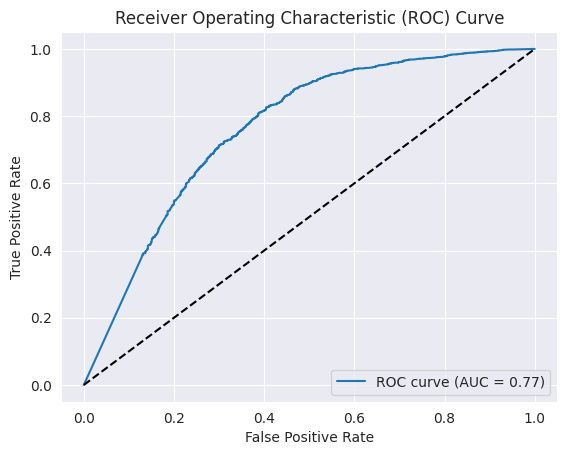

In [153]:

fpr, tpr, thresholds = roc_curve(y_test, rf_predictions)


plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest Parameters

In [156]:
print(rf_model.feature_importances_)
print(rf_model.n_estimators)

[0.01543325 0.01484526 0.01472208 0.03030768 0.20173167 0.02788625
 0.39898205 0.29609175]
100
DecisionTreeClassifier(max_features='sqrt', random_state=1608637542)


AttributeError: 'RandomForestClassifier' object has no attribute 'oob_score_'